In [1]:
import torch
import time
import matplotlib.pyplot as plt
import non_local_boxes

# Sugar coating for reloading
%matplotlib inline
%load_ext autoreload
%autoreload 2

# 1. Basic Gradient Descent

## 1.1. Constraint => Projection

As we maximize under constraints, we need the orthogonal projection onto the unit hypercube $[0,1]^{32}$:

In [2]:
# def projected_wiring_basic(W):  # W is a 32xn tensor
#     W = torch.maximum(W, torch.zeros_like(W))  # it outputs the element-wise maximum
#     W = torch.minimum(W, torch.ones_like(W))   # similarly for minimum
#     return W

In [3]:
# def projected_wiring_old(W):  # W is a 32xn tensor
#     W = torch.maximum(W, torch.zeros_like(W))  # it outputs the element-wise maximum
#     W = torch.minimum(W, torch.ones_like(W))   # similarly for minimum

#     # Then we verify the 4 equalities of (5)
#     for alpha in range(non_local_boxes.evaluate.nb_columns):
#         #1
#         if abs(W[0, alpha] - W[1, alpha]) <= abs(W[8, alpha] - W[9, alpha]):
#             W[0, alpha] = (W[0, alpha]+W[1, alpha])/2
#             W[1, alpha] = W[0, alpha]
#         else:
#             W[8, alpha] = (W[8, alpha]+W[9, alpha])/2
#             W[9, alpha] = W[8, alpha]
            
#         #2
#         if abs(W[2, alpha] - W[3, alpha]) <= abs(W[10, alpha] - W[11, alpha]):
#             W[2, alpha] = (W[2, alpha]+W[3, alpha])/2
#             W[3, alpha] = W[2, alpha]
#         else:
#             W[10, alpha] = (W[10, alpha]+W[11, alpha])/2
#             W[11, alpha] = W[10, alpha]
            
#         #3
#         if abs(W[4, alpha] - W[5, alpha]) <= abs(W[12, alpha] - W[13, alpha]):
#             W[4, alpha] = (W[4, alpha]+W[5, alpha])/2
#             W[5, alpha] = W[4, alpha]
#         else:
#             W[12, alpha] = (W[12, alpha]+W[13, alpha])/2
#             W[13, alpha] = W[12, alpha]
                
#         #4
#         if abs(W[6, alpha] - W[7, alpha]) <= abs(W[14, alpha] - W[15, alpha]):
#             W[6, alpha] = (W[6, alpha]+W[7, alpha])/2
#             W[7, alpha] = W[6, alpha]
#         else:
#             W[14, alpha] = (W[14, alpha]+W[15, alpha])/2
#             W[15, alpha] = W[14, alpha]

#     return W

In [4]:
M1 = torch.zeros(32, 32)
for i in range(32):
    M1[i,i]=1
M1[0,0]=0.5
M1[0,1]=0.5
M1[1,0]=0.5
M1[1,1]=0.5

M2 = torch.zeros(32, 32)
for i in range(32):
    M2[i,i]=1
M2[8,8]=0.5
M2[8,9]=0.5
M2[9,8]=0.5
M2[9,9]=0.5

M3 = torch.zeros(32, 32)
for i in range(32):
    M3[i,i]=1
M3[2,2]=0.5
M3[2,3]=0.5
M3[3,2]=0.5
M3[3,3]=0.5

M4 = torch.zeros(32, 32)
for i in range(32):
    M4[i,i]=1
M4[10,10]=0.5
M4[10,11]=0.5
M4[11,10]=0.5
M4[11,11]=0.5

M5 = torch.zeros(32, 32)
for i in range(32):
    M5[i,i]=1
M5[4,4]=0.5
M5[4,5]=0.5
M5[5,4]=0.5
M5[5,5]=0.5

M6 = torch.zeros(32, 32)
for i in range(32):
    M6[i,i]=1
M6[12,12]=0.5
M6[12,13]=0.5
M6[13,12]=0.5
M6[13,13]=0.5

M7 = torch.zeros(32, 32)
for i in range(32):
    M7[i,i]=1
M7[6,6]=0.5
M7[6,7]=0.5
M7[7,6]=0.5
M7[7,7]=0.5

M8 = torch.zeros(32, 32)
for i in range(32):
    M8[i,i]=1
M8[14,14]=0.5
M8[14,15]=0.5
M8[15,14]=0.5
M8[15,15]=0.5


In [5]:
def projected_wiring(W):  # W is a 32xn tensor
    W = torch.maximum(W, torch.zeros_like(W))  # it outputs the element-wise maximum
    W = torch.minimum(W, torch.ones_like(W))   # similarly for minimum

    T1 = (torch.abs(W[0,:]-W[1,:]) <= torch.abs(W[8, :] - W[9, :]))
    # If T1[i] is True: W[:,i] becomes M1 . W[:,i]
    # Otherwise: W[:,i] becomes M2 . W[:,i]
    W = T1*torch.tensordot(M1, W, dims=1) + torch.logical_not(T1)*torch.tensordot(M2, W, dims=1)
    
    T2 = (torch.abs(W[2,:]-W[3,:]) <= torch.abs(W[10, :] - W[11, :]))
    # If T2[i] is True: W[:,i] becomes M3 . W[:,i]
    # Otherwise: W[:,i] becomes M4 . W[:,i]
    W = T2*torch.tensordot(M3, W, dims=1) + torch.logical_not(T2)*torch.tensordot(M4, W, dims=1)

    T3 = (torch.abs(W[4,:]-W[5,:]) <= torch.abs(W[12, :] - W[13, :]))
    # If T3[i] is True: W[:,i] becomes M5 . W[:,i]
    # Otherwise: W[:,i] becomes M6 . W[:,i]
    W = T3*torch.tensordot(M5, W, dims=1) + torch.logical_not(T3)*torch.tensordot(M6, W, dims=1)

    T4 = (torch.abs(W[6,:]-W[7,:]) <= torch.abs(W[14, :] - W[15, :]))
    # If T4[i] is True: W[:,i] becomes M7 . W[:,i]
    # Otherwise: W[:,i] becomes M8 . W[:,i]
    W = T4*torch.tensordot(M7, W, dims=1) + torch.logical_not(T4)*torch.tensordot(M8, W, dims=1)

    return W

In [6]:
# W = non_local_boxes.utils.random_wiring(non_local_boxes.evaluate.nb_columns).detach()
# projected_wiring(W) == projected_wiring_old(W)

In [7]:
W = non_local_boxes.utils.W_BS09(non_local_boxes.evaluate.nb_columns).detach()
P = non_local_boxes.utils.SR
Q = non_local_boxes.utils.PR
float(non_local_boxes.evaluate.phi_flat(W, P, Q)[0])

0.875

## 1.2. Gradient Descent

In [12]:
def gradient_descent(starting_W, P, Q, learning_rate = 2, nb_iterations = 20):
    external_grad = torch.ones(non_local_boxes.evaluate.nb_columns)
    W = starting_W
    for i in range(nb_iterations):
        non_local_boxes.evaluate.phi_flat(W, P, Q).backward(gradient=external_grad)
        W = projected_wiring(W + learning_rate*W.grad).detach()  # create a brand new tensor, forgeting the previous gradient
        W.requires_grad=True
    return W

In [13]:
# Initialization
starting_W = non_local_boxes.utils.random_wiring(non_local_boxes.evaluate.nb_columns)
P = non_local_boxes.utils.SR
Q = non_local_boxes.utils.PR
learning_rate = 2
nb_iterations = 20


# Gradient Descent
print("(Iterating...)")
tic = time.time()
W = gradient_descent(starting_W, P, Q, learning_rate, nb_iterations)
toc = time.time()


# Result
list = non_local_boxes.evaluate.phi_flat(W, P, Q).detach().numpy()
print("")
print("Number of tested wirings: ", len(list))
print("--> Min:    ", min(list))
print("--> Av.:    ", sum(list)/len(list))
index, value = max(enumerate(list), key=lambda x: x[1])
best_wiring = W[:,index].detach().numpy()
print("--> Max:    ", value)
print("Duration: ", (toc-tic)*1e0, "s")
print("")
print("-----")
print("The best wiring is:\n", best_wiring)
print("-----")
non_local_boxes.utils.wiring_to_functions(best_wiring)

(Iterating...)

Number of tested wirings:  1000
--> Min:     0.74737376
--> Av.:     0.7902006754279136
--> Max:     1.0
Duration:  0.3158600330352783 s

-----
The best wiring is:
 [0.32223618 0.02889622 0.42890984 0.42890984 0.2155349  0.2155349
 0.3752831  0.3752831  0.         0.         1.         1.
 0.         1.         1.         0.         1.         0.
 0.         1.         1.         0.         1.         0.
 1.         0.         0.         1.         1.         0.
 0.         1.        ]
-----
f_1(x,a2) =  0.10667365789413452 x ⊕  1.7066600322723389 a2 ⊕  0.29333996772766113 x*a2 ⊕  0.32223618030548096
g_1(y,b2) =  0.15974819660186768 y ⊕  0.0 b2 ⊕  0.0 y*b2 ⊕  0.21553489565849304
f_2(x,a1) =  1.0 x ⊕  0.0 a1 ⊕  0.0 x*a1 ⊕  0.0
g_2(y,b1) =  1.0 y ⊕  1.0 b1 ⊕  0.0 y*b1 ⊕  0.0
f_3(x,a1,a2) =  0.0 x ⊕  1.0 a1 ⊕  1.0 a2 ⊕  0.0 x*a1 ⊕  1.0 x*a2 ⊕  0.0 a1*a2 ⊕  0.0 x*a1*a2 ⊕  1.0
g_3(y,b1,b2) =  0.0 y ⊕  1.0 b1 ⊕  1.0 b2 ⊕  0.0 y*b1 ⊕  0.0 y*b2 ⊕  0.0 b1*b2 ⊕  0.0 y*b1*b2 ⊕  1.

In [11]:
#assert(False)

In [ ]:
# [0.24272715, 0.12160056, 0.9498826 , 0.02322189, 0.39412087,
#        0.39412087, 0.83709   , 0.52627677, 0.        , 0.        ,
#        1.        , 1.        , 0.        , 0.        , 1.        ,
#        1.        , 1.        , 0.        , 1.        , 0.        ,
#        1.        , 0.        , 1.        , 0.        , 1.        ,
#        0.        , 1.        , 0.        , 1.        , 0.        ,
#        1.        , 0.        ]

In [ ]:
# W = torch.t(torch.tensor([[0., 0., 1. , 0., 0.,
#        0., 1.   , 0.5 , 0.        , 0.        ,
#        1.        , 1.        , 0.        , 0.        , 1.        ,
#        1.        , 1.        , 0.        , 1.        , 0.        ,
#        1.        , 0.        , 1.        , 0.        , 1.        ,
#        0.        , 1.        , 0.        , 1.        , 0.        ,
#        1.        , 0.        ]]))

# P = non_local_boxes.utils.SR
# Q = non_local_boxes.utils.PR
# float(non_local_boxes.evaluate.phi_flat(W, P, Q)[0])

## 1.3 Test in the triangle PR-P0-P1

0.7500001
0.75000006
0.7500002
0.7500001
0.7500002
0.7500001
0.7500002
0.7500001
0.7500002
0.75000006
0.75000006
0.79313576
0.7889071
0.786723
0.78338444
0.7811709
0.78003
0.7789736
0.7781179
0.7787453
0.7869785
0.8347523
0.82546246
0.8266636
0.8238039
0.8257775
0.8298522
0.82777315
0.8268069
0.8347924
0.8773559
0.86874676
0.86249995
0.85500014
0.85500014
0.85469794
0.85775423
0.86562604
0.90999997
0.90000004
0.89000005
0.88
0.8860955
0.8983254
0.901743
0.9375
0.92499995
0.9125001
0.9125
0.92499995
0.9375
0.96000016
0.94500005
0.93000007
0.94500005
0.96000016
0.97749996
0.96000004
0.96000004
0.97749996
0.99000007
0.97
0.99
0.99750006
0.99750006
1.0


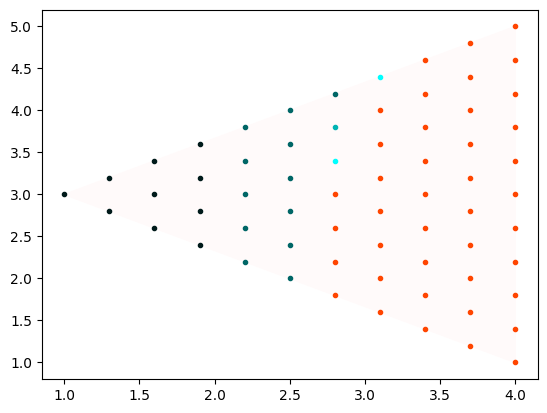

In [31]:
#plt.ion()

X = torch.tensor([[1,3], [4,1], [4, 5]]).numpy()

triangle = plt.Polygon(X[:3,:], color="snow")
plt.gca().add_patch(triangle)

threshold = (3 + float(torch.sqrt(torch.tensor(6))))/6
box_grid_size = 10
max_box_power = 3

PR = non_local_boxes.utils.PR
P_0 = non_local_boxes.utils.P_0
P_1 = non_local_boxes.utils.P_1
W_BS09 = non_local_boxes.utils.W_BS09(non_local_boxes.evaluate.nb_columns).detach()
W_random = non_local_boxes.utils.random_wiring(non_local_boxes.evaluate.nb_columns)

for i in range(box_grid_size+1):
    for j in range(box_grid_size-i+1):
        alpha = i/box_grid_size
        beta = j/box_grid_size
        P = alpha*PR + beta*P_0 + (1-alpha-beta)*P_1   # P is a 4x4 matrix
        color_point = "orangered"

        # Given a box P, we look for the W maximizing P x_W P
        W = gradient_descent(W_random, P, P, learning_rate=2, nb_iterations=20)
        list = non_local_boxes.evaluate.phi_flat(W, P, P).detach().numpy()
        index, value = max(enumerate(list), key=lambda x: x[1])
        best_wiring = W[:,index].detach()
        best_wiring = torch.t(best_wiring.repeat(non_local_boxes.evaluate.nb_columns, 1))
        print(value)
        
        Q=torch.clone(P)
        Q=non_local_boxes.utils.matrix_to_tensor(Q)  # Q is a 2x2x2x2 tensor 
        for k in range(max_box_power+1):
            if non_local_boxes.evaluate.h_flat(Q)[0] > threshold:
                color_point = (0, 0.1*(1-k/max_box_power)+1*(k/max_box_power), 0.1*(1-k/max_box_power)+1*(k/max_box_power))
                break
            #Q2=Q.copy()
            Q=non_local_boxes.evaluate.R(best_wiring, non_local_boxes.utils.tensor_to_matrix(Q), P)[:,:,:,:,0]

        plt.plot(X[0,0]*alpha + X[1,0]*beta + X[2,0]*(1-alpha-beta), X[0,1]*alpha + X[1,1]*beta + X[2,1]*(1-alpha-beta), 'o', markersize=3, color=color_point)
                

plt.show()

## Gradient Descent of $W\mapsto P^{\boxtimes_W N}$

In [77]:
def gradient_descent_power(starting_W, P, N, learning_rate = 2, nb_iterations = 20):
    external_grad = torch.ones(non_local_boxes.evaluate.nb_columns)
    W = starting_W
    for i in range(nb_iterations):
        evaluate = non_local_boxes.evaluate.phi_power(W, P, N)
        evaluate.backward(gradient=external_grad)
        W = projected_wiring(W + learning_rate*W.grad).detach()  # create a brand new tensor, forgeting the previous gradient
        W.requires_grad=True
    return W

>À faire : il faut modifier phi_power et mettre des noms différents pour les Q, sinon l'algo ne retrouve pas les gradients...

In [90]:
n = non_local_boxes.evaluate.nb_columns
W = non_local_boxes.utils.random_wiring(n)
P = non_local_boxes.utils.corNLB(0.5)
gradient_descent_power(W, P, 2, 2, 20)

external_grad = torch.ones(non_local_boxes.evaluate.nb_columns)
Q2 = non_local_boxes.evaluate.R(W, P, P)
Q3 = torch.zeros(2, 2, 2, 2, n)
for alpha in range(n):
    Q3[:,:,:,:,alpha] = non_local_boxes.evaluate.R(W, non_local_boxes.utils.tensor_to_matrix(Q2[:,:,:,:,alpha]), P)[:,:,:,:,alpha]
non_local_boxes.evaluate.phi_flat(W, non_local_boxes.utils.tensor_to_matrix(Q3[:,:,:,:,0]), P).backward(gradient=external_grad)
W.grad



# external_grad = torch.ones(non_local_boxes.evaluate.nb_columns)
# Q = torch.clone(P)
# Q = non_local_boxes.utils.matrix_to_tensor(Q) # Q is a 2x2x2x2 tensor
# Q = non_local_boxes.evaluate.R(W, P, P) # Now on, Q is a 2x2x2x2xn tensor
# non_local_boxes.evaluate.h_flat(Q).backward(gradient=external_grad)
# W.grad


tensor([[ 6.0099e-04, -4.4725e-03,  3.5374e-04],
        [-1.8745e-02, -4.9862e-03, -2.4925e-03],
        [-2.7166e-04, -2.5097e-03, -2.3121e-02],
        [ 2.1049e-04,  7.4555e-04, -5.5780e-03],
        [ 3.4417e-03, -1.8211e-03, -4.8662e-03],
        [-6.8108e-04,  1.6722e-04,  1.4523e-03],
        [-1.0678e-03,  2.3658e-04, -4.6821e-03],
        [-4.7678e-04,  2.8962e-03, -5.3823e-03],
        [ 2.2791e-03, -6.3192e-03, -1.1344e-02],
        [-1.4330e-02, -1.3797e-02, -7.3381e-03],
        [ 5.3122e-03,  1.6776e-03,  2.4258e-03],
        [ 2.0824e-03,  1.9197e-03, -1.3548e-03],
        [ 1.7112e-02, -1.2112e-02, -5.1996e-03],
        [-2.5172e-02, -1.4577e-02,  1.4974e-03],
        [ 9.7705e-03, -3.3744e-02, -2.0748e-02],
        [ 3.0705e-04,  1.3508e-02, -1.2788e-02],
        [-2.5946e-02, -9.4414e-02, -8.1388e-02],
        [-7.4618e-02,  7.9424e-02, -1.7998e-01],
        [-1.1561e-02, -1.2653e-01, -5.4068e-02],
        [-1.3533e-01, -4.2896e-02, -1.1946e-01],
        [-7.6270e-02

In [62]:
n = non_local_boxes.evaluate.nb_columns
W = non_local_boxes.utils.W_BS09(n)
P = non_local_boxes.utils.corNLB(0.5)
print(non_local_boxes.evaluate.phi_power(W, P, 3))
Q = non_local_boxes.evaluate.R(W, P, P)[:,:,:,:,0]
Q = non_local_boxes.utils.tensor_to_matrix(Q)
print(non_local_boxes.evaluate.phi_flat(W, Q, P))

tensor([0.9297, 0.9297, 0.9297], grad_fn=<ReshapeAliasBackward0>)
tensor([0.9297, 0.9297, 0.9297], grad_fn=<ReshapeAliasBackward0>)


Gradient Descent for each power:

In [ ]:
#plt.ion()

X = torch.tensor([[1,3], [4,1], [4, 5]]).numpy()

triangle = plt.Polygon(X[:3,:], color="snow")
plt.gca().add_patch(triangle)

threshold = (3 + float(torch.sqrt(torch.tensor(6))))/6
box_grid_size = 10
max_box_power = 3

PR = non_local_boxes.utils.PR
P_0 = non_local_boxes.utils.P_0
P_1 = non_local_boxes.utils.P_1
W_BS09 = non_local_boxes.utils.W_BS09(non_local_boxes.evaluate.nb_columns).detach()
W_random = non_local_boxes.utils.random_wiring(non_local_boxes.evaluate.nb_columns)

for i in range(box_grid_size+1):
    for j in range(box_grid_size-i+1):
        alpha = i/box_grid_size
        beta = j/box_grid_size
        P = alpha*PR + beta*P_0 + (1-alpha-beta)*P_1   # P is a 4x4 matrix
        color_point = "orangered"

        # Given a box P, we look for the W maximizing P x_W P
        W = gradient_descent(W_random, P, P, learning_rate=2, nb_iterations=20)
        list = non_local_boxes.evaluate.phi_flat(W, P, P).detach().numpy()
        index, value = max(enumerate(list), key=lambda x: x[1])
        best_wiring = W[:,index].detach()
        best_wiring = torch.t(best_wiring.repeat(non_local_boxes.evaluate.nb_columns, 1))
        print(value)
        
        Q=torch.clone(P)
        Q=non_local_boxes.utils.matrix_to_tensor(Q)  # Q is a 2x2x2x2 tensor 
        for k in range(max_box_power+1):

            # faire une descente de gradient sur la fonction puissance

            if non_local_boxes.evaluate.h_flat(Q)[0] > threshold:
                color_point = (0, 0.1*(1-k/max_box_power)+1*(k/max_box_power), 0.1*(1-k/max_box_power)+1*(k/max_box_power))
                break
            #Q2=Q.copy()
            Q=non_local_boxes.evaluate.R(best_wiring, non_local_boxes.utils.tensor_to_matrix(Q), P)[:,:,:,:,0]

        plt.plot(X[0,0]*alpha + X[1,0]*beta + X[2,0]*(1-alpha-beta), X[0,1]*alpha + X[1,1]*beta + X[2,1]*(1-alpha-beta), 'o', markersize=3, color=color_point)
                

plt.show()